In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
import matplotlib.pyplot as plt


In [59]:
features_df = pd.read_csv('combined_user_features.csv')
print("Số dòng dữ liệu:", features_df.shape[0])

Số dòng dữ liệu: 25669


In [60]:
features_df.head(5)

,profile_id,in_degree,out_degree,betweenness,closeness,eigenvector,gnn_emb_0,gnn_emb_1,gnn_emb_2,gnn_emb_3,...,gnn_emb_6,gnn_emb_7,gnn_emb_8,gnn_emb_9,gnn_emb_10,gnn_emb_11,gnn_emb_12,gnn_emb_13,gnn_emb_14,gnn_emb_15
0,14,61,54,0.010998,0.191469,0.0,0.211611,-0.269107,0.273392,-0.296295,...,-0.035242,0.167099,0.160259,-0.274770,0.529678,-0.592954,-0.434381,0.631305,0.125773,-0.164979
1,512,0,1,0.000000,0.000000,0.0,-0.331892,0.245718,-0.127536,1.064909,...,-0.488813,2.731494,-0.168228,0.574580,-0.725955,1.440069,0.988772,0.479626,-0.398622,-0.433876
2,533,1,1,0.000000,0.183487,0.0,0.500691,0.150737,-0.137665,-1.646185,...,2.055947,-1.145390,-0.191167,-0.272023,0.046450,0.523815,-0.108906,-0.663571,-0.155089,0.510967
3,534,3252,2825,0.170321,0.254787,0.0,-0.007179,0.653304,-0.476211,0.049931,...,-0.598944,0.423170,-0.127218,-0.617603,0.993495,0.103717,-1.163863,1.333986,-0.777232,0.013848
4,564,110,3,0.000269,0.194558,0.0,-0.534705,1.021134,-0.330630,-0.251206,...,-1.197644,-0.229253,-0.486613,0.555429,-0.294560,-0.526531,-0.462786,0.312274,0.514031,0.776007


In [61]:
features_df['follower_following_ratio'] = features_df.apply(
    lambda row: row['in_degree'] / row['out_degree'] if row['out_degree'] > 0 else row['in_degree'], axis=1)

In [62]:
features_df.head(5)

,profile_id,in_degree,out_degree,betweenness,closeness,eigenvector,gnn_emb_0,gnn_emb_1,gnn_emb_2,gnn_emb_3,...,gnn_emb_7,gnn_emb_8,gnn_emb_9,gnn_emb_10,gnn_emb_11,gnn_emb_12,gnn_emb_13,gnn_emb_14,gnn_emb_15,follower_following_ratio
0,14,61,54,0.010998,0.191469,0.0,0.211611,-0.269107,0.273392,-0.296295,...,0.167099,0.160259,-0.274770,0.529678,-0.592954,-0.434381,0.631305,0.125773,-0.164979,1.129630
1,512,0,1,0.000000,0.000000,0.0,-0.331892,0.245718,-0.127536,1.064909,...,2.731494,-0.168228,0.574580,-0.725955,1.440069,0.988772,0.479626,-0.398622,-0.433876,0.000000
2,533,1,1,0.000000,0.183487,0.0,0.500691,0.150737,-0.137665,-1.646185,...,-1.145390,-0.191167,-0.272023,0.046450,0.523815,-0.108906,-0.663571,-0.155089,0.510967,1.000000
3,534,3252,2825,0.170321,0.254787,0.0,-0.007179,0.653304,-0.476211,0.049931,...,0.423170,-0.127218,-0.617603,0.993495,0.103717,-1.163863,1.333986,-0.777232,0.013848,1.151150
4,564,110,3,0.000269,0.194558,0.0,-0.534705,1.021134,-0.330630,-0.251206,...,-0.229253,-0.486613,0.555429,-0.294560,-0.526531,-0.462786,0.312274,0.514031,0.776007,36.666667


In [63]:
# Chọn các chỉ số mạng và một phần vector nhúng (có thể dùng toàn bộ hoặc trích chọn các chiều quan trọng)
gnn_emb_cols = [col for col in features_df.columns if col.startswith('gnn_emb_')]
selected_cols = ['in_degree', 'out_degree', 'follower_following_ratio', 'betweenness', 'closeness', 'eigenvector'] + gnn_emb_cols

X = features_df[selected_cols].values

In [64]:
#Chuẩn hóa
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [65]:
# 5. Xác định số lượng cụm (k) bằng Silhouette Score (tùy chọn)
# ---------------------------
k_values = range(2,10)
sil_scores = []
db_scores = []
ch_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    
    # Tính Silhouette Score
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)
    
    # Tính Davies-Bouldin Index
    db = davies_bouldin_score(X_scaled, labels)
    db_scores.append(db)
    
    # Tính Calinski-Harabasz Score
    ch = calinski_harabasz_score(X_scaled, labels)
    ch_scores.append(ch)
    print(f"[k={k}] Silhouette Score = {sil:.4f}, Davies-Bouldin = {db:.4f}, Calinski-Harabasz Score = {ch:.4f}" )


[k=2] Silhouette Score = 0.0405, Davies-Bouldin = 4.8455, Calinski-Harabasz Score = 889.0979
[k=3] Silhouette Score = 0.0408, Davies-Bouldin = 4.0905, Calinski-Harabasz Score = 863.3006
[k=4] Silhouette Score = 0.0371, Davies-Bouldin = 4.4445, Calinski-Harabasz Score = 735.8587
[k=5] Silhouette Score = 0.0389, Davies-Bouldin = 3.6053, Calinski-Harabasz Score = 1468.4287
[k=6] Silhouette Score = 0.0378, Davies-Bouldin = 3.4625, Calinski-Harabasz Score = 1285.6249
[k=7] Silhouette Score = 0.0363, Davies-Bouldin = 3.2754, Calinski-Harabasz Score = 1148.2675
[k=8] Silhouette Score = 0.0352, Davies-Bouldin = 3.0597, Calinski-Harabasz Score = 1041.1191
[k=9] Silhouette Score = 0.0366, Davies-Bouldin = 2.8318, Calinski-Harabasz Score = 1131.4308


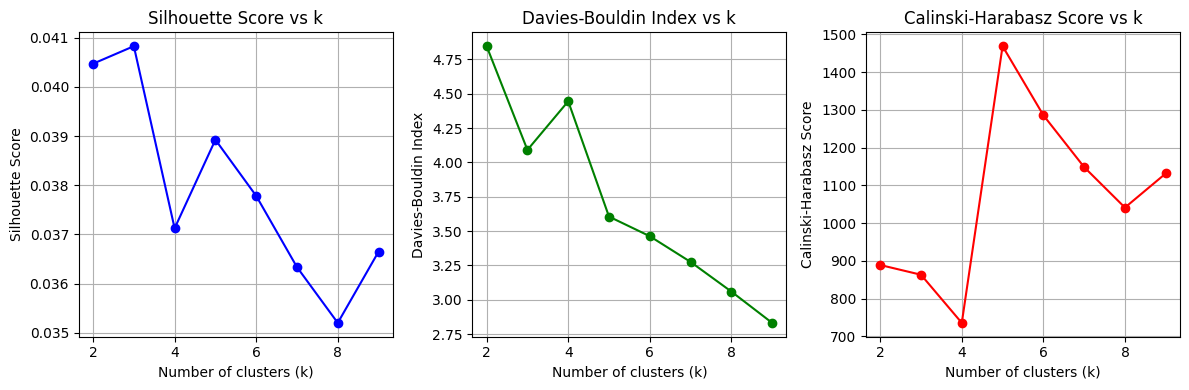

In [66]:
plt.figure(figsize=(12,4))

# Silhouette Score
plt.subplot(1, 3, 1)
plt.plot(k_values, sil_scores, marker='o', color='blue')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs k")
plt.grid(True)

# Davies-Bouldin Index (càng thấp càng tốt)
plt.subplot(1, 3, 2)
plt.plot(k_values, db_scores, marker='o', color='green')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Davies-Bouldin Index")
plt.title("Davies-Bouldin Index vs k")
plt.grid(True)

# Calinski-Harabasz Score (càng cao càng tốt)
plt.subplot(1, 3, 3)
plt.plot(k_values, ch_scores, marker='o', color='red')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Calinski-Harabasz Score")
plt.title("Calinski-Harabasz Score vs k")
plt.grid(True)

plt.tight_layout()
plt.show()

In [67]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
features_df['cluster'] = kmeans.fit_predict(X_scaled)

In [69]:
# 6. Kiểm tra trung tâm các cụm để xem đặc trưng nào nổi bật
# ---------------------------
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(cluster_centers, columns=selected_cols)
print("Trung tâm các cụm:")
print(centers_df)

Trung tâm các cụm:
     in_degree   out_degree  follower_following_ratio   betweenness  \
0     0.349927     1.297965                  0.264773  3.355361e-06   
1     0.283920     1.283455                  0.193270  8.331693e-08   
2     2.144046     2.024247                  1.189801  4.575508e-05   
3     3.880748     2.436962                  2.056628  6.614957e-05   
4  2146.750000  1873.000000                  1.162584  1.054021e-01   

   closeness  eigenvector  gnn_emb_0  gnn_emb_1  gnn_emb_2  gnn_emb_3  ...  \
0   0.015310          0.0   0.130800   0.183149  -0.066887  -0.592765  ...   
1   0.002347          0.0  -0.103651  -0.144835   0.039573   0.437687  ...   
2   0.158115          0.0   0.401799  -0.286576   0.130169   0.218584  ...   
3   0.158707          0.0  -0.429464   0.289401  -0.117192  -0.135480  ...   
4   0.250619          0.0  -0.090060   0.481584  -0.370080   0.033234  ...   

   gnn_emb_6  gnn_emb_7  gnn_emb_8  gnn_emb_9  gnn_emb_10  gnn_emb_11  \
0  -0.081310

<Figure size 1200x600 with 0 Axes>

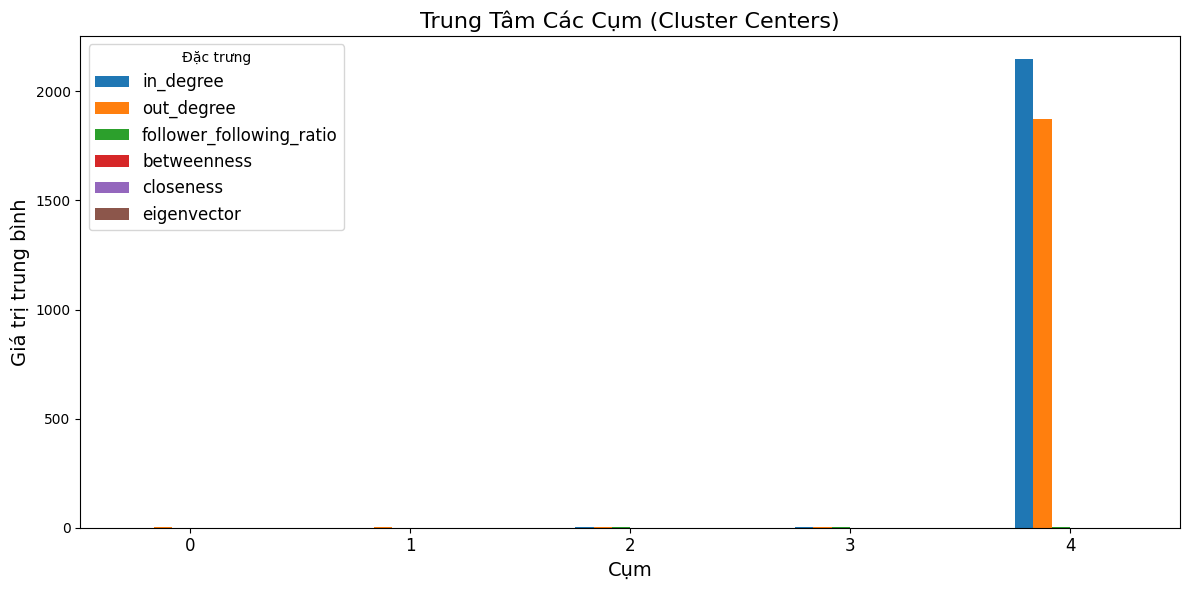

In [72]:
center_label = pd.DataFrame(centers_df.iloc[:, :6])
plt.figure(figsize=(12, 6))
center_label.plot(kind="bar", figsize=(12, 6))

# Đặt tiêu đề và nhãn
plt.title("Trung Tâm Các Cụm (Cluster Centers)", fontsize=16)
plt.xlabel("Cụm", fontsize=14)
plt.ylabel("Giá trị trung bình", fontsize=14)
plt.xticks(rotation=0, fontsize=12)  # Hiển thị tên cụm
plt.legend(title="Đặc trưng", fontsize=12)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

In [ ]:
role_map = {
    0: 'Influencers',       # Ví dụ: cụm có tỷ lệ follower/following cao, betweenness cao
    1: 'Active Followers',  # Ví dụ: cụm có out_degree lớn nhưng in_degree thấp
    2: 'Community Leaders', # Ví dụ: cụm có closeness hoặc degree cao
    3: 'Lurkers',           # Ví dụ: cụm có cả in_degree và out_degree nhỏ
    4: 'Bridge Builders'    # Ví dụ: cụm có betweenness cao, đóng vai trò cầu nối
}

features_df['role'] = features_df['cluster'].map(role_map)

In [27]:
features_df.to_csv('user_roles_clustered.csv', index=False)
print("Đã lưu kết quả phân cụm và gán nhãn vai trò vào file 'user_roles_clustered.csv'")
print("Phân bố các vai trò:")
print(features_df['role'].value_counts())

Đã lưu kết quả phân cụm và gán nhãn vai trò vào file 'user_roles_clustered.csv'
Phân bố các vai trò:
role
Community Leaders    6966
Lurkers              6741
Active Followers     6450
Influencers          5508
Bridge Builders         4
Name: count, dtype: int64
